In [1]:
Mjj_selection = 1000.

vae_loss = 'mae'

SM_eff = 1e-2

# dVar_label = '$L_1/P^1_T + L_2/P^2_T$ [GeV^-1]'
# def computeDiscriminatingVar(x):
#     out = x[:,-2]/x[:,1]+x[:,-1]/x[:,6]
#     out *= 1e5
#     return out

dVar_label = '$L_1 + L_2$'
def computeDiscriminatingVar(x):
    out = x[:,-2]+x[:,-1]
    return out*1e4

# Imports

In [2]:
from __future__ import print_function

import h5py, os, sys, glob, datetime, time
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
from prettytable import PrettyTable

import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar

from cebefo_style import cebefo_style
cebefo_style()

dnd = []

Welcome to JupyROOT 6.16/00


# Get the discrimination on the side-band

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1Loss', 'j2Loss']
(38568, 13)


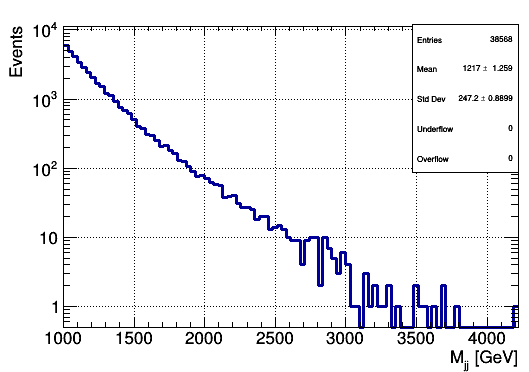

In [3]:
f = h5py.File('../data/vae_'+vae_loss+'/qcd_dEta_sideband_results.h5', 'r')
print(list(f.get("labels")))

data_side = np.array(f.get("results"))

# apply the dijet mass cut
data_side = data_side[data_side[:,0] > Mjj_selection]
print(data_side.shape)

c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_side = create_TH1D(data_side[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                opt='overflow', 
                binning=[100, Mjj_selection, np.max(data_side[:,0])])

h_Mjj_side.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

In [4]:
gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=5,
                                min_samples_split=5,
                                validation_fraction=0.5,
                                n_iter_no_change=5,
                                tol=1e-5,
                                verbose=2)

x = np.reshape(data_side[:,0], (-1,1))
y = computeDiscriminatingVar(data_side)
gbr_cut.fit(x, y);

date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
joblib.dump(gbr_cut, '../models/gbr_cut_trained_{}.joblib'.format(date_str)) 

      Iter       Train Loss   Remaining Time 
         1          50.7603            1.54s
         2          46.5842            1.54s
         3          43.6680            1.95s
         4          41.1444            1.79s
         5          39.4709            1.69s
         6          37.5082            1.61s
         7          35.8464            1.55s
         8          34.4341            1.51s
         9          32.9958            1.47s
        10          31.7456            1.45s
        11          30.6797            1.42s
        12          29.7219            1.41s
        13          28.7996            1.39s
        14          27.9701            1.38s
        15          27.4008            1.36s
        16          26.7423            1.34s
        17          26.1031            1.33s
        18          25.5552            1.32s
        19          25.1158            1.31s
        20          24.7234            1.30s
        21          24.3752            1.29s
        2

['../models/gbr_cut_trained_20190802.joblib']

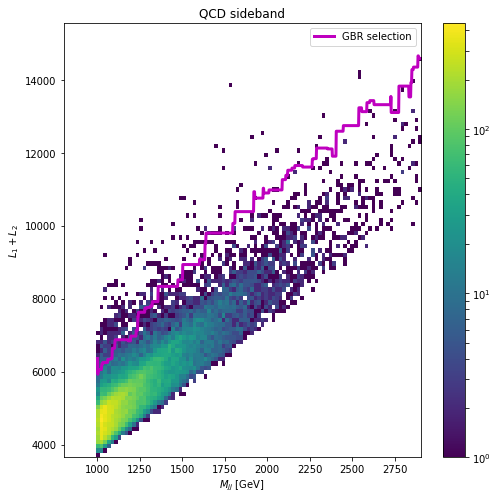

In [5]:
plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = np.quantile(x, 0.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.quantile(y, 1-1e-4))), 
           norm=LogNorm(), bins=100,
           label='Side band data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel(dVar_label)
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.title('QCD sideband')
plt.legend(loc='best')
plt.draw()

In [6]:
def getSelection(x_Mjj, x_loss):
    cut = gbr_cut.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut

In [7]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

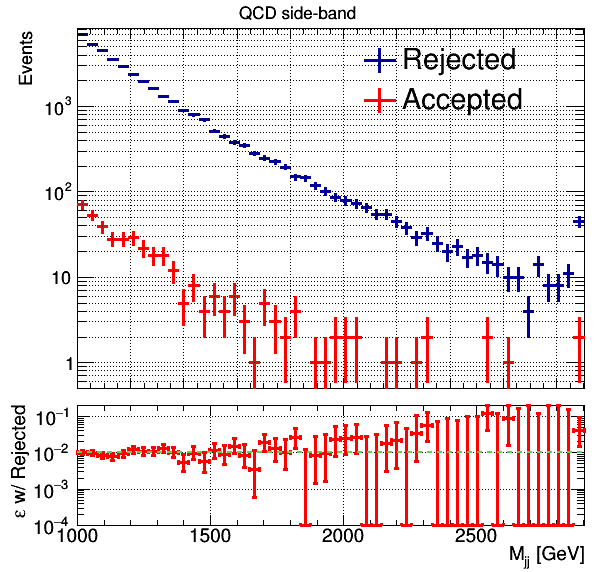

In [8]:
x = x.flatten()
binning=[50, Mjj_selection, np.quantile(x, 0.999)]

sel = getSelection(x, y)

c = plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'QCD side-band')
h_a = c.h_list[1]
h_r = c.h_list[0]

# Analyze signal region

In [9]:
sample_loc = {'qcd':'qcd_dEta_signalregion_results.h5',
              'AtoZZZ':'AtoHZ_to_ZZZ_13TeV_PU40_results.h5',
              'GtoWW':'RSGraviton_WW_NARROW_13TeV_PU40_results.h5',
              'GtoBtt':'RSGraviton_tt_BROAD_13TeV_PU40_results.h5',
              'GtoNtt':'RSGraviton_tt_NARROW_13TeV_PU40_results.h5'
             }

sample_label = {'qcd':r'QCD',
                'AtoZZZ':r'$A\to ZZZ$',
                'GtoWW':r'$G\to WW$',
                'GtoBtt':r'$G_{B}\to t\bar{t}$',
                'GtoNtt':r'$G_{N}\to t\bar{t}$'
               }

sample_label_ROOT = {'qcd':'QCD',
                'AtoZZZ':'A #rightarrow ZZZ',
                'GtoWW':'G #rightarrow WW',
                'GtoBtt':'G_{B} #rightarrow t#bar{t}',
                'GtoNtt':'G_{N} #rightarrow t#bar{t}'
               }

SM_samples = ['qcd']
BSM_samples = ['AtoZZZ', 'GtoWW', 'GtoBtt', 'GtoNtt']

sample_nGenEvts = {'qcd': 418*10000,
                   'AtoZZZ': 100*1000,
                   'GtoWW': 100*1000,
                   'GtoBtt': 96*1000,
                   'GtoNtt': 96*1000
                  }

sample_xsec = {'qcd': 8734.0 #pb
              }

### Get the data

In [10]:
data = {}
sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

for n, fname in sample_loc.iteritems():
    f = h5py.File('../data/vae_'+vae_loss+'/'+fname, 'r')
    x = np.array(f.get("results"))

    # apply the dijet mass cut
    sel_Mjj = x[:,0] > Mjj_selection
    x = x[sel_Mjj]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(x[:,0], dVar)
    x = np.column_stack((x, dVar, sel))
    
    sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n]
    
    dt = [(str(s), '<f4') for s in list(f.get("labels")) + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.2f}'.format(100*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100*sample_eff[n]), np.sum(data[n]['sel']), eff])
    
print(table)

+--------+----------+--------------+---------------+-------------+
| Sample | Trg evts | Eff. trg [%] | VAE sel. evts | Eff VAE [%] |
+--------+----------+--------------+---------------+-------------+
| GtoBtt |  65082   |     67.8     |     27125     |    41.68    |
| GtoWW  |  52408   |     52.4     |     14365     |    27.41    |
| GtoNtt |  63748   |     66.4     |     27142     |    42.58    |
| AtoZZZ |  63490   |     63.5     |     29913     |    47.11    |
|  qcd   |  86911   |     2.1      |      859      |     0.99    |
+--------+----------+--------------+---------------+-------------+


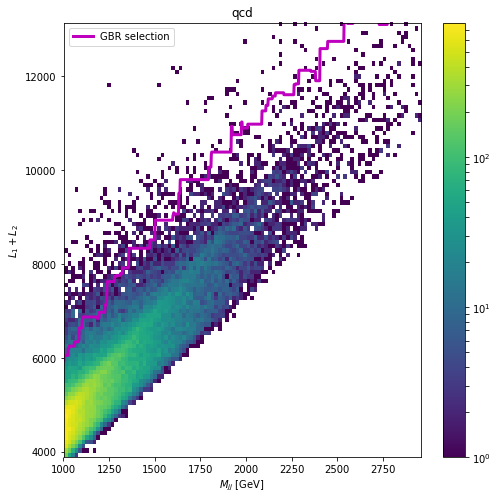

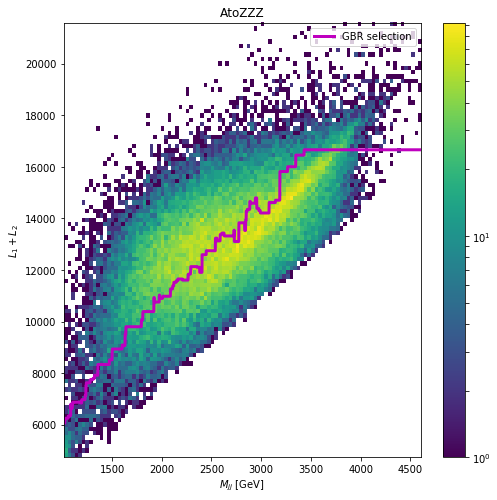

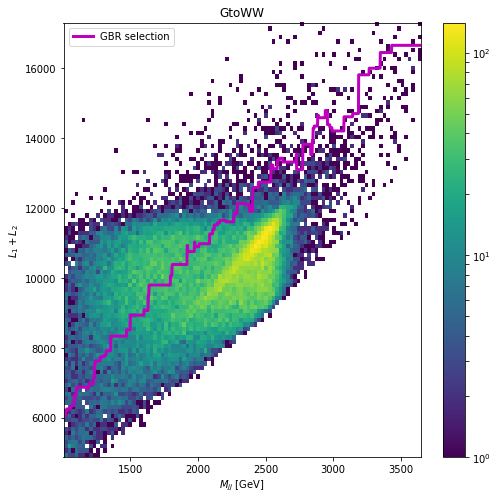

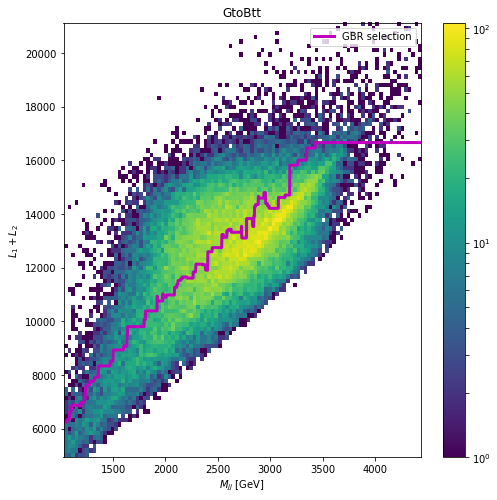

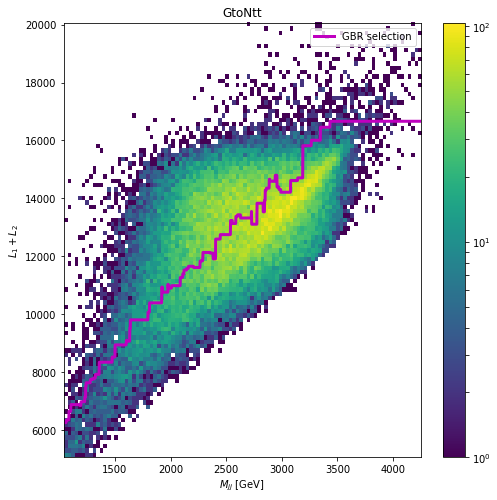

In [11]:
for n in SM_samples + BSM_samples:
    x_min, x_max = np.quantile(data[n]['mJJ'], [0.001, 0.999])
    y_min, y_max = np.quantile(data[n]['dVar'], [0.001, 0.999])

    plt.figure(figsize=(8, 8))
    plt.hist2d(data[n]['mJJ'], data[n]['dVar'],
               range=((x_min, x_max), (y_min, y_max)), 
               norm=LogNorm(), bins=100,
               label='Side band data'
              )

    xs = np.arange(x_min, x_max, 0.001*(3000-Mjj_selection))
    plt.plot(xs, gbr_cut.predict(np.reshape(xs, (-1,1))), '-', color='m', lw=3, label='GBR selection')

    plt.ylabel(dVar_label)
    plt.xlabel('$M_{jj}$ [GeV]')
    plt.colorbar()
    plt.title(n)
    plt.legend(loc='best')
    plt.draw()